## Deep MMD - GAN with Celeb-A dataset


In [1]:
%matplotlib inline

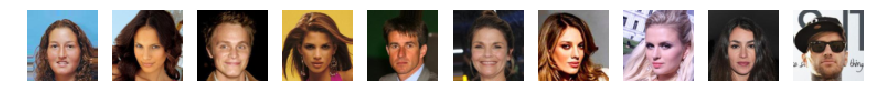

In [2]:
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms

from utils import GeneratorNet, DiscriminatorNet, show_images


class options:
    cuda = True
    batch_size = 128
    image_size = 64
    n_filters = 100
    
transform = transforms.Compose([
    transforms.Scale( options.image_size ),
    transforms.CenterCrop(options.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./datasets/celeb-splitted/', transform=transform), 
    batch_size=options.batch_size, shuffle=True, num_workers=1)


for x, _ in dataloader:
    show_images(x)
    break

0 0 1583 17.27845573425293


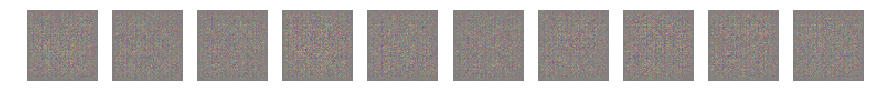

0 700 1583 43.813175201416016


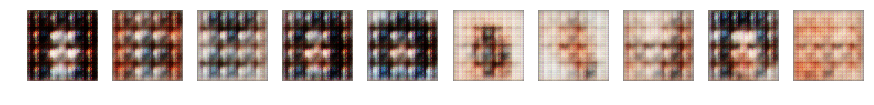

0 1400 1583 27.874645233154297


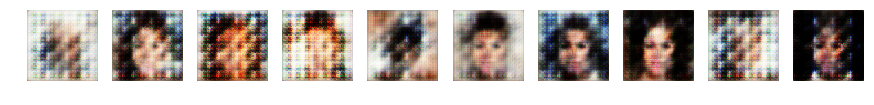

1 0 1583 32.490501403808594


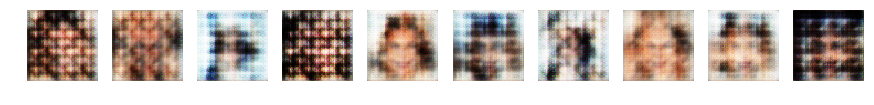

1 700 1583 37.007537841796875


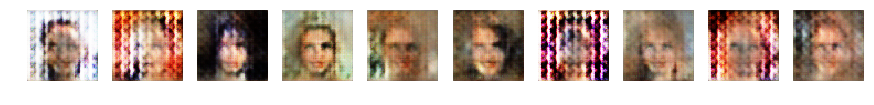

1 1400 1583 34.615474700927734


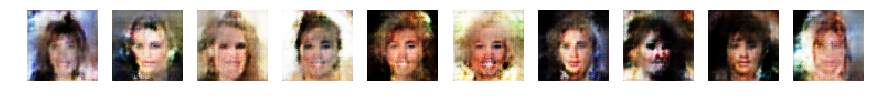

2 0 1583 32.11695861816406


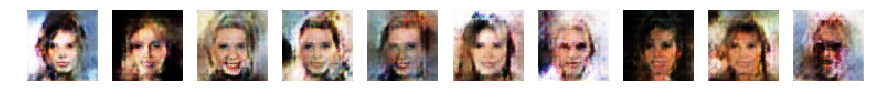

2 700 1583 27.686769485473633


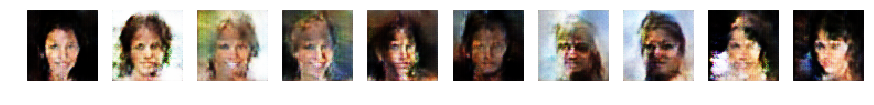

2 1400 1583 28.31241798400879


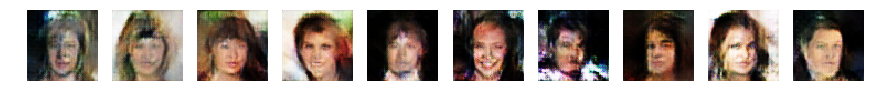

3 0 1583 27.612417221069336


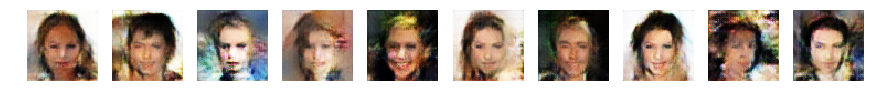

3 700 1583 23.002424240112305


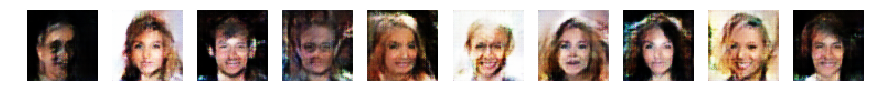

3 1400 1583 23.9964599609375


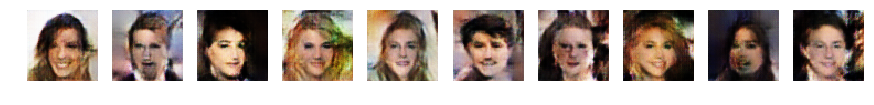

4 0 1583 24.749961853027344


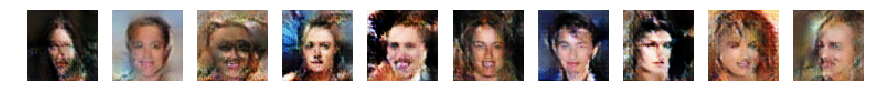

4 700 1583 21.246862411499023


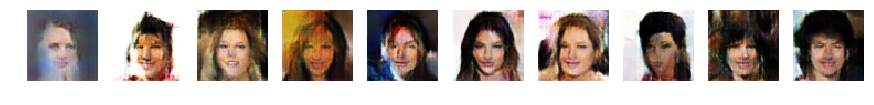

4 1400 1583 29.33506202697754


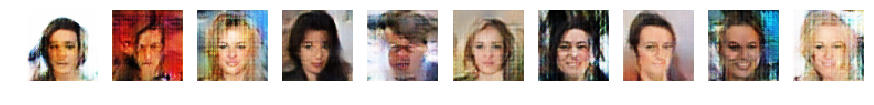

5 0 1583 26.898836135864258


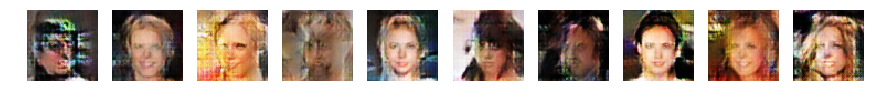

5 700 1583 31.994770050048828


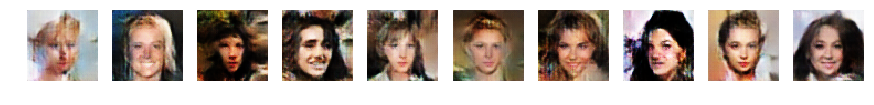

5 1400 1583 25.04816436767578


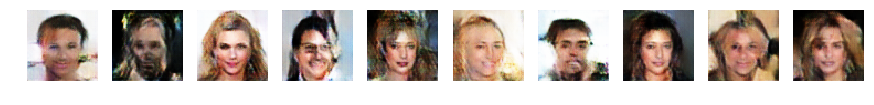

6 0 1583 15.08940601348877


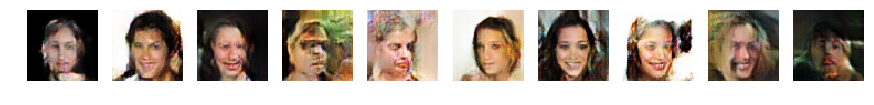

6 700 1583 29.776906967163086


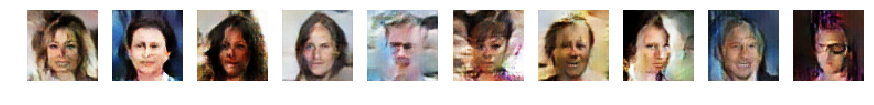

6 1400 1583 20.187593460083008


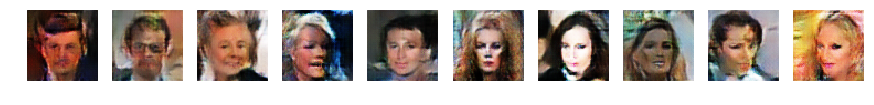

7 0 1583 28.11534881591797


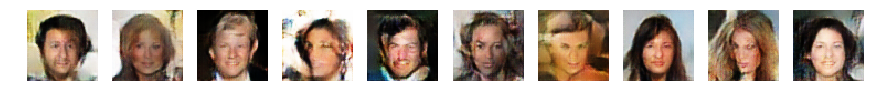

7 700 1583 22.666425704956055


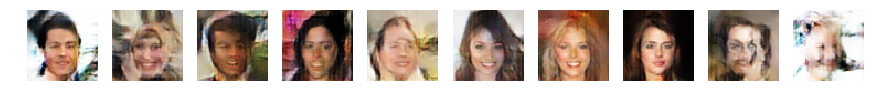

7 1400 1583 23.232532501220703


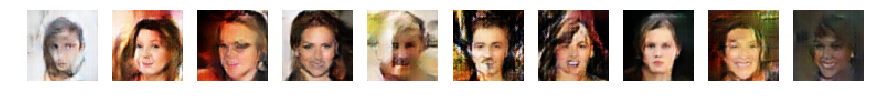

8 0 1583 28.09041976928711


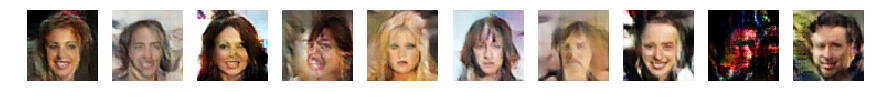

8 700 1583 25.12018585205078


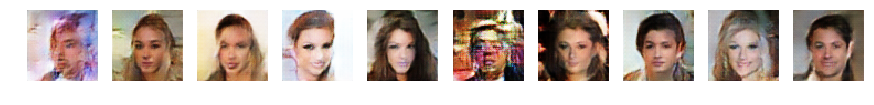

8 1400 1583 29.054126739501953


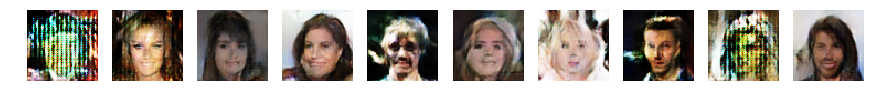

9 0 1583 23.6715030670166


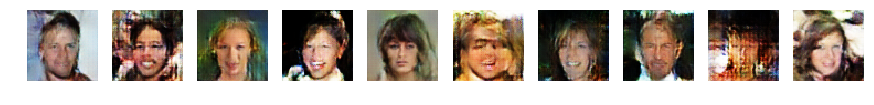

9 700 1583 17.652799606323242


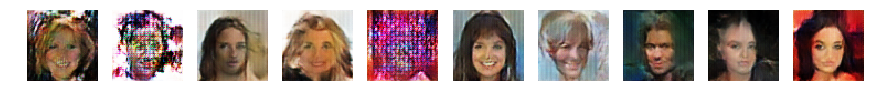

9 1400 1583 29.400543212890625


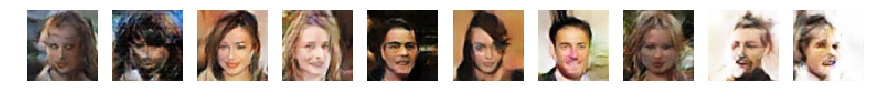

10 0 1583 28.402891159057617


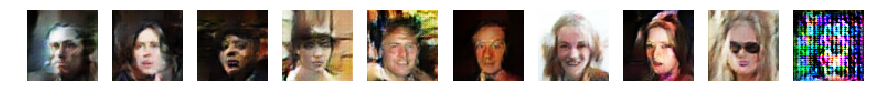

10 700 1583 31.881380081176758


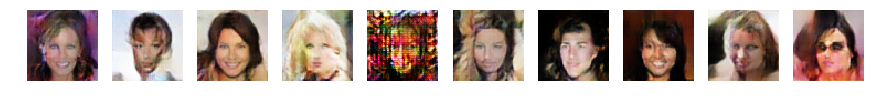

10 1400 1583 20.435020446777344


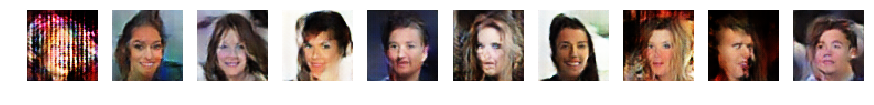

11 0 1583 26.26020622253418


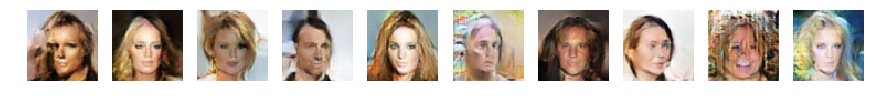

11 700 1583 21.84563636779785


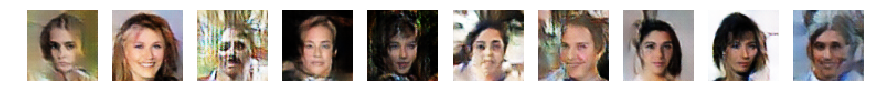

11 1400 1583 32.82930374145508


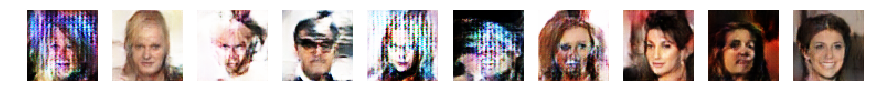

12 0 1583 27.71941566467285


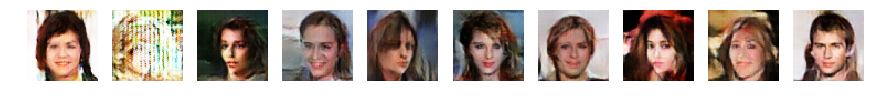

12 700 1583 26.678791046142578


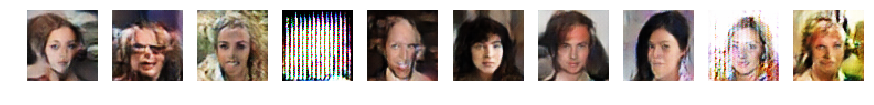

12 1400 1583 22.86192512512207


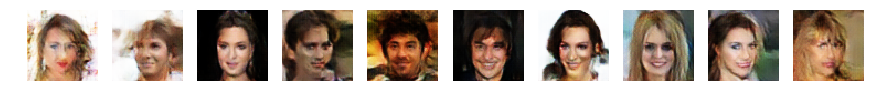

13 0 1583 31.133052825927734


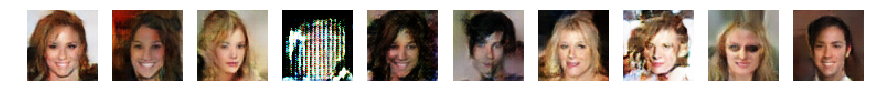

13 700 1583 24.314773559570312


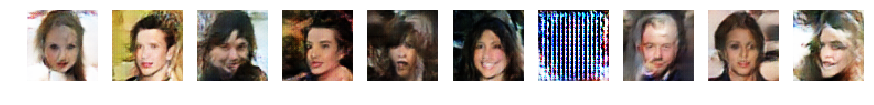

13 1400 1583 22.623170852661133


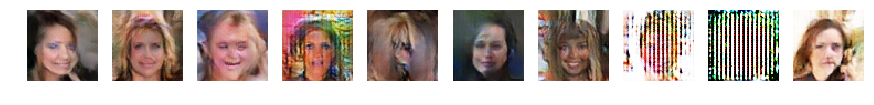

14 0 1583 32.14295196533203


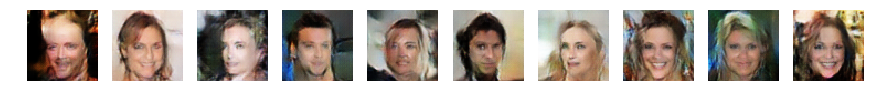

14 700 1583 26.33431625366211


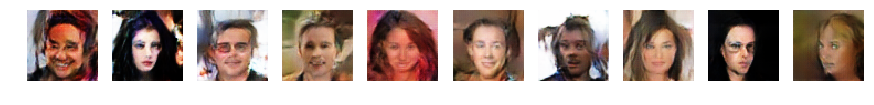

14 1400 1583 27.300559997558594


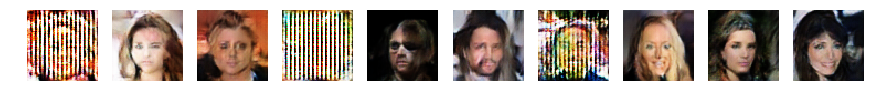

15 0 1583 32.14507293701172


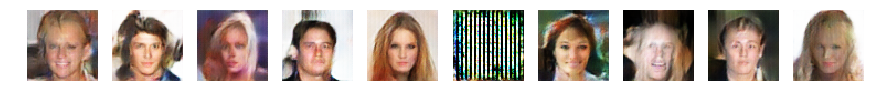

15 700 1583 31.61588478088379


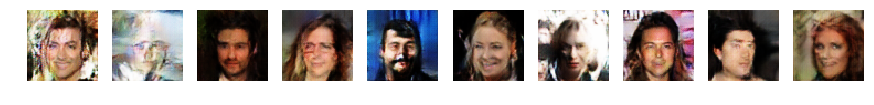

15 1400 1583 21.84130859375


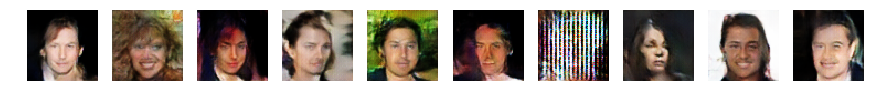

16 0 1583 26.92314910888672


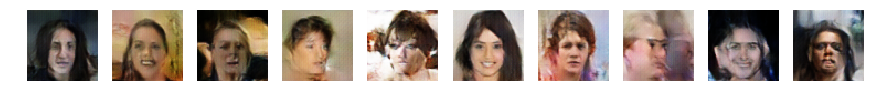

16 700 1583 19.83055877685547


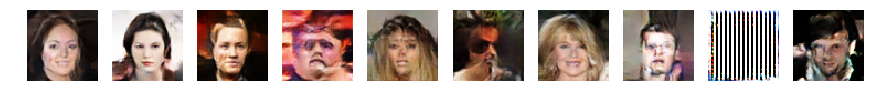

16 1400 1583 26.59833335876465


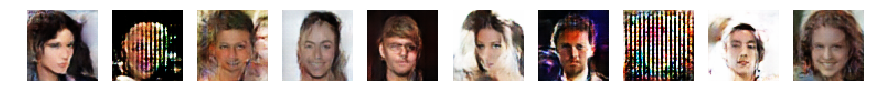

17 0 1583 22.9151554107666


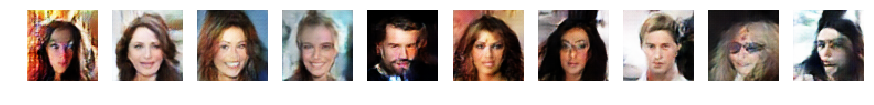

17 700 1583 23.899980545043945


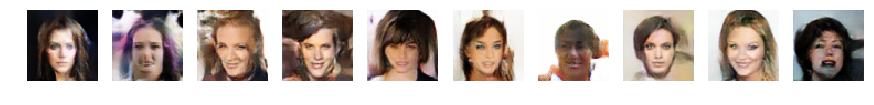

17 1400 1583 33.04496765136719


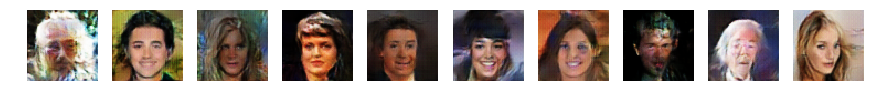

18 0 1583 25.261972427368164


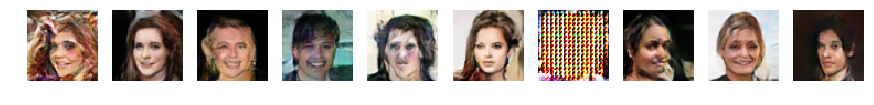

18 700 1583 19.032732009887695


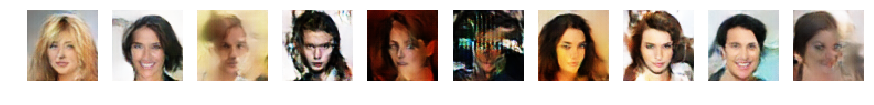

18 1400 1583 19.107534408569336


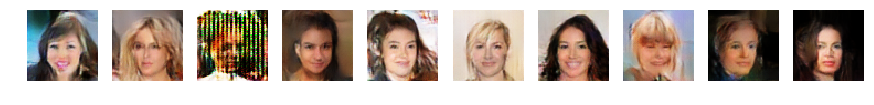

19 0 1583 15.624719619750977


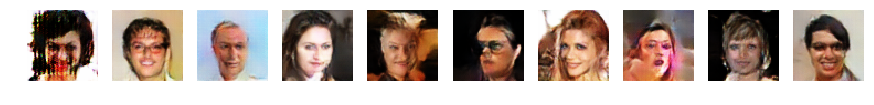

19 700 1583 21.376018524169922


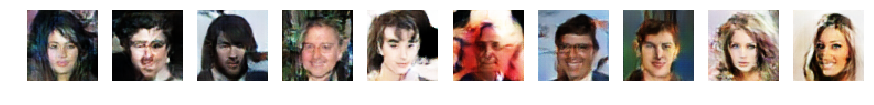

19 1400 1583 21.772069931030273


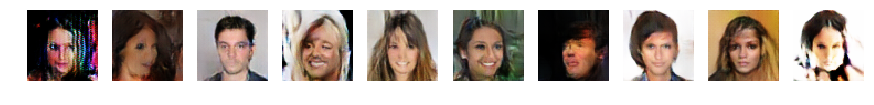

In [3]:
netG = GeneratorNet(input_nfilters=options.n_filters, generator_nfilters=64, 
                    image_size=options.image_size, n_colors=3)
netD = DiscriminatorNet(discriminator_nfilters=32, image_size=options.image_size, n_colors=3)

criterion = nn.BCELoss()

noise = torch.FloatTensor(options.batch_size, options.n_filters, 1, 1)

if options.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    noise = noise.cuda()

# setup optimizer.
# Yup, just added minus to learning rate - and that's where you get adversarial training :)
optimizerD = optim.Adam(netD.parameters(), lr=-1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=+1e-4, betas=(0.5, 0.999))

for epoch in range(20):
    for i, (real_cpu, _) in enumerate(dataloader):
        netD.zero_grad()
        netG.zero_grad()

        # get real batch
        if options.cuda:
            real_cpu = real_cpu.cuda()
        real = Variable(real_cpu)

        # generate fake
        noise.normal_(0, 1)
        fake = netG(Variable(noise))

        # joint to have common batch-norm transform
        outputs = netD(torch.cat([real, fake], dim=0))
        output_real = outputs[:real.size(0)]
        output_fake = outputs[real.size(0):]

        MMD = torch.norm(output_fake.mean(dim=0) - output_real.mean(dim=0))
        MMD.backward()

        optimizerD.step()
        optimizerG.step()

        if i % 700 == 0:
            print(epoch, i, len(dataloader), MMD.data[0])
            show_images(fake.data)